##### 목표 : 미니배치기반 기계학습 진행 실습
- 확률적경사하강법 기반의 알고리즘 적용 모델
- 데이터의 처음부터 끝까지(에포크) 학습 후 가중치와 절편 업데이트 하는 방식  
  => 에포크를 미니배치만큼 나눠서 학습 후 가중치와 절편 업데이트 진행함  
<hr>

- 장점
1) 온라인 학습, 점진적 학습 가능 => partial_fit() : 기존 모델에 추가로 1에포크 학습
2) 기존의 다른 모델보다 속도 빠름 => 랜덤으로 한 개 추출 후 학습 진행
- 단점
1) 전체 학습보다 정확도는 떨어질 수 있음

1. Data prepare

In [1]:
import pandas as pd

fishDF = pd.read_csv('../../DATA/fish.csv')
fishDF

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,Smelt,12.2,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,14.3,15.2,2.8728,2.0672


2. Data preprocessing for train

In [2]:
# 2-1. split feature and target
featureDF = fishDF.drop(['Species'], axis=1)
targetDF = fishDF['Species']
print('shape:', featureDF.shape, targetDF.shape)

# 2-2. split train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, 
                                                    random_state=41,stratify=targetDF)
print('[train] shape :', X_train.shape, y_train.shape)
print('[test] shape :', X_test.shape, y_test.shape)

# 2-3. feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

shape: (159, 5) (159,)
[train] shape : (119, 5) (119,)
[test] shape : (40, 5) (40,)


3. 학습 진행 : SGD Classifier
- : 확률적경사하강법 기반의 분류

In [3]:
# Create model1 : SGD Classifier
from sklearn.linear_model import SGDClassifier

model1 = SGDClassifier(random_state=41, verbose=0, loss='log_loss', n_iter_no_change=999)
# n_iter_no_change= : 
model1.fit(X_train_scaled, y_train)

# Check scores
train_score1 = model1.score(X_train_scaled, y_train)
test_score1 = model1.score(X_test_scaled, y_test)
print(f'[기본 SGD] 학습 점수 : {train_score1:.3f}, 테스트 점수 : {test_score1:.3f}')



[기본 SGD] 학습 점수 : 0.941, 테스트 점수 : 0.950


c:\Users\wjs31\.conda\envs\EXAM_MML\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


##### 최적의 학습 횟수(n_iter_) 찾기
- max_iter를 변경하면 성능이 좋아진다!

In [4]:
 # max_iter 값에 따른 n_iter_와 성능 차이
 
print('model.n_iter :', model1.n_iter_)      
# n_iter_no_change 변경 없을 때 : 34, 성능 0.882
# n_iter_no_change = 1000 : 1000, 성능 : 0.950

model.n_iter : 1000


1 에포크 씩 점진적으로 학습 진행 => partial_fit()

In [5]:
# 모델 인스턴스 생성
import numpy as np

# n_iter_no_change=1 인 model2 생성
model2 = SGDClassifier(random_state=41, verbose=0, loss='log_loss', n_iter_no_change=1)

print(np.unique(y_train))   # class 정보를 직접 입력
model2.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
# partial_fit() : 
# classes : 타겟의 클래스 (종류), 

# Check scores
train_score2 = model2.score(X_train_scaled, y_train)
test_score2 = model2.score(X_test_scaled, y_test)
print(f'[n_iter_ = 1] 학습 점수 : {train_score2:.3f}, 테스트 점수 : {test_score2:.3f}')

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
[n_iter_ = 1] 학습 점수 : 0.723, 테스트 점수 : 0.700


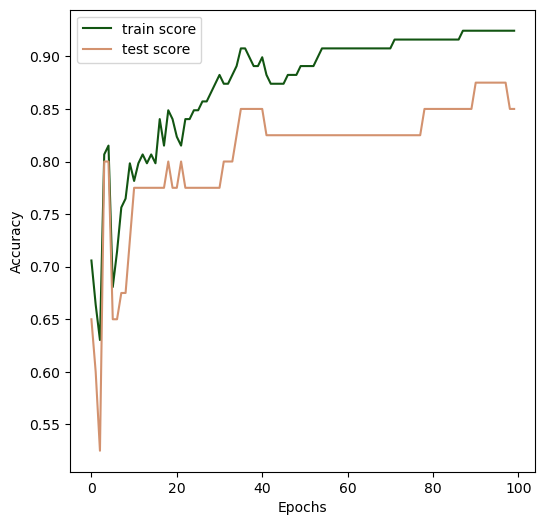

In [6]:
# for 반복 : model에 선언된 n_iter_n_c 가 1 이므로
#            반복 실행 시 1 에포크 씩 학습한다
train_score, test_score = [], []
for n in range(100):
    model2.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
    train_score2 = model2.score(X_train_scaled, y_train)
    test_score2 = model2.score(X_test_scaled, y_test)
    train_score.append(train_score2)
    test_score.append(test_score2)
    if abs(test_score2 - train_score2) > 0.03:  # test와 train의 차이가 작을 때
        if test_score2 > 0.90:
            break

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(train_score,'#125512', label='train score')
plt.plot(test_score, '#D3926F', label='test score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### penalty, alpha 적용
1) penalty=L2 :  
2) alpha=0.0001 : 가중치의 크기를 조절하는 가중치 정도
- 과대적합 시 규제는 강하게 적용 -> 가중치의 값을 작게 -> 완만한 그래프
- 

In [9]:
# 모델 인스턴스 생성

model3 = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0000001, random_state=42)
model3.fit(X_train_scaled, y_train)
# 학습 점수와 테스트 점수 계산
train_score3 = model3.score(X_train_scaled, y_train)
test_score3 = model3.score(X_test_scaled, y_test)
print(f'train score : {train_score3:.3f}')
print(f'test score : {test_score3:.3f}')

# 이런 식으로 가중치를 조절할 수 있다~

train score : 0.748
test score : 0.700


In [ ]:
# fin.